In [1]:
#Necessary import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from yahoofinancials import YahooFinancials as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

### Data Gathering

In [2]:
# Picking the stock to predict and get historical data

def get_stock_data(tickers, start_date='2020-01-01', end_date='2020-03-31', freq='daily'):
    '''This function takes the list of stock ticker and get historical OHLC data
    
    Parameters
    ----------
    tickers : list/iterable
        Iterable object containing ticker symbols as strings
    start_date : str, optional
        Takes start date of data, format = 'yyyy-mm-dd'
    end_date : str, optional
        Takes end date of data, format = 'yyyy-mm-dd'
        
    Returns
    -------
    pandas DataFrame containing pricing data and list containing tickers whose data was not found
    
    '''

    ticker_not_found=[]
    for ticker in tickers:
        yf_engine = yf(ticker)
        price = yf_engine.get_historical_price_data(start_date,end_date,freq)
        #store the data in DataFrame
        try:
            ticker_data = pd.DataFrame(price[ticker]['prices'])
            ticker_data = ticker_data.drop('date', axis=1) # We will use formatted_date columns instead
        except:
            ticker_not_found.append(ticker)
            continue
            
    return ticker_data, ticker_not_found
    


In [3]:
#We will use Google stock ticker to predict its prices
ticker = ['GOOG']
start_date = '2019-07-01'
end_date = '2020-10-01'

df, ticker_not_found = get_stock_data(ticker, start_date, end_date)

df.head()

,high,low,open,close,volume,adjclose,formatted_date
0,1107.579956,1093.703003,1098.000000,1097.949951,1436300,1097.949951,2019-07-01
1,1111.770020,1098.170044,1102.239990,1111.250000,991600,1111.250000,2019-07-02
2,1126.760010,1113.859985,1117.410034,1121.579956,767000,1121.579956,2019-07-03
3,1132.880005,1116.140015,1117.800049,1131.589966,1264300,1131.589966,2019-07-05
4,1125.979980,1111.209961,1125.170044,1116.349976,1236400,1116.349976,2019-07-08


### Data cleaning
Check whether there are any nan values and outliers

In [4]:
df.describe()

,high,low,open,close,volume,adjclose
count,317.000000,317.000000,317.000000,317.000000,3.170000e+02,317.000000
mean,1354.950609,1325.563112,1339.367906,1341.140739,1.711825e+06,1341.140739
std,142.949930,140.825268,142.171799,141.665824,7.526484e+05,141.665824
min,1071.319946,1013.536011,1056.510010,1056.619995,3.475000e+05,1056.619995
25%,1234.000000,1207.764038,1220.969971,1217.140015,1.246000e+06,1217.140015
50%,1353.093018,1329.084961,1341.500000,1343.560059,1.519300e+06,1343.560059
75%,1469.520020,1437.130005,1457.069946,1456.160034,1.879800e+06,1456.160034
max,1733.180054,1666.329956,1709.713989,1728.280029,4.805800e+06,1728.280029


In [5]:
df[df.isna()==True].sum().sum()

0.0

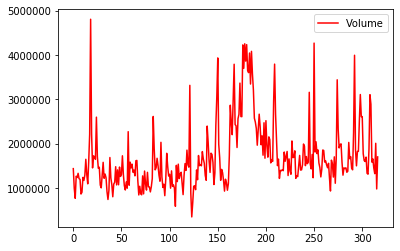

In [6]:
df['volume'].plot(label='Volume', color='r');
plt.legend();

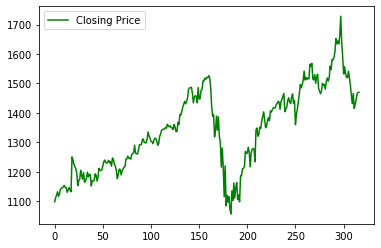

In [7]:
df['adjclose'].plot(label='Closing Price', color='g');
plt.legend();

As the mean and median (50%) is not so far off for every column except volume that means there are no outliers and there is no np.nan values in dataframe as well. Please note that high volume is not an outlier and instead in my opinion will serve as unique data point for make prediction for my classifier

### Feature Engineering
We will now create certain features from the pricing data which would include:  
1) SMA_20 : Simple Moving Average of 20 day window  
2) Std_dev : Standard Deviation for 20 day window  
3) Band_1 : Bollinger band created using SMA_20 + Std_dev  
4) Band_2 : Bollinger band created using SMA_20 - Std_dev  
5) ON_returns : whether there was up or down move from prior day closing price to current day opening price   
6) dist_from_mean : How much distant stock prices are from the mean   
7) vix_data: CBOE Volatility index price from the prior day

In [8]:
def get_clean_data (df, start_date, end_date):
    '''This function takes the historical OHLC data and return features as we defined above
    
    Parameters
    ----------
    df : DataFrame
        Dataframe containing pricing data
    start_date : str, optional
        Takes start date of data for vix, format = 'yyyy-mm-dd'
    end_date : str, optional
        Takes ebd date of data for vix, format = 'yyyy-mm-dd'
        
    Returns
    -------
    pandas DataFrame containing scaled features except categorical features
    '''
    
    features = df.copy()
    features = features.drop(['formatted_date'], axis=1)
    #creating features as stated above
    features['volume'] = features['volume'].shift(1)
    features['SMA'] = features['adjclose'].rolling(window=20).mean().shift(1)
    features['Std_20'] = features['adjclose'].rolling(window=20).std().shift(1)
    features['Band_1'] = features['SMA'] - features['Std_20']
    features['Band_2'] = features['SMA'] + features['Std_20']
    features['ON_returns'] = features['close'] - features['open'].shift(-1)
    features['ON_returns'] = features['ON_returns'].shift(1)
    features['ON_returns_signal'] = np.where(features['ON_returns']<0, 'up', 'down')
    features['dist_from_mean'] = features['adjclose'].shift(1) - features['SMA']
    #Obtaining Vix Data and combining with existing features of stock
    ticker = ['^VIX']
    start_date = start_date
    end_date = end_date
    vix_data, ticker_not_found = get_stock_data(ticker, start_date, end_date)
    vix_data = pd.DataFrame(vix_data['adjclose'].shift(1))
    vix_data = vix_data.rename(columns = {'adjclose':'vix_data'})
    comb_features = pd.concat([features,vix_data], axis=1)
    comb_features = comb_features.dropna() #dropping NaN values
    comb_features = pd.get_dummies(comb_features, columns=['ON_returns_signal']) #for categorical variables
    comb_features = comb_features.drop('ON_returns', axis=1) #dropping original categorical column
    comb_features = comb_features.drop('close', axis=1) #not really needed this value since we have adj close now
    ###Create return column to predict
    comb_features['stock_move'] = np.where(comb_features['adjclose']-
                                           comb_features['adjclose'].shift(-1)<0, "Buy", "Sell")
    features_clean = comb_features.dropna() #Dropping Nan values
    features_clean = features_clean[:-1] #Drop last row which do not have any stock signal
    features_clean.tail()
    return features_clean


In [9]:
features = get_clean_data(df, start_date, end_date)

In [10]:
features.tail()

,high,low,open,volume,adjclose,SMA,Std_20,Band_1,Band_2,dist_from_mean,vix_data,ON_returns_signal_down,ON_returns_signal_up,stock_move
311,1460.959961,1407.699951,1458.780029,1583200.0,1415.209961,1568.562000,79.469414,1489.092586,1648.031413,-103.102039,26.860001,1,0,Buy
312,1443.708984,1409.849976,1411.030029,1657400.0,1428.290039,1558.911499,85.862135,1473.049364,1644.773634,-143.701538,28.580000,1,0,Buy
313,1450.000000,1413.339966,1432.630005,1450200.0,1444.959961,1547.707001,87.626181,1460.080819,1635.333182,-119.416962,28.510000,0,1,Buy
314,1476.800049,1449.301025,1474.209961,1323000.0,1464.520020,1538.238501,88.003880,1450.234621,1626.242381,-93.278540,26.379999,0,1,Buy
315,1476.662964,1458.805054,1470.390015,2007900.0,1469.329956,1529.244000,85.745331,1443.498670,1614.989331,-64.723981,26.190001,0,1,Buy


### Finding correlation using correlation matric

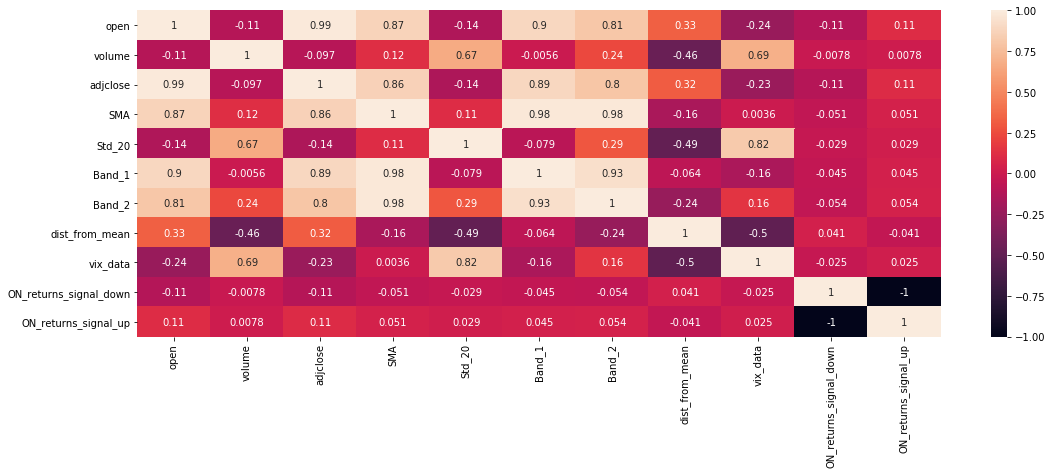

In [11]:
corr_table = features.drop(['high', 'low'], axis=1).corr()
fig, ax = plt.subplots(figsize=(18,6))
sn.heatmap(corr_table, annot = True, ax=ax)
plt.show()

### Q1- Whether historical price and volume data can serve as potential features to predict the respective stock prices?

We can see that historical pricing data like opening price and moving average are strongly correlated with the closing price. Since they are correlated, they can be used to predict future prices.

### Q2-Whether overall historical stock market volatility has any correlation with the price data of a given stock and hence whether can be used as a feature as well?
Volatility index has strong negative correlation with the stock price (-0.23) and very strongly correlated to stock's volatility as well as its volume and therefore we will use this as a feature for our classification model as well.

### Prediction Classifier

In [12]:
X = features.drop(['stock_move','high', 'low'], axis=1)
y = features['stock_move']

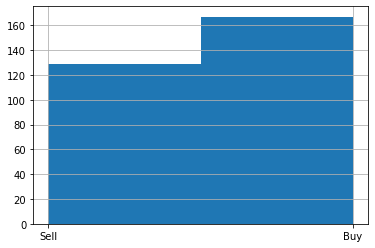

In [13]:
y.hist(bins=2);

Since predictions are somewhat evenly distributed so there is lesser chance of bias in our predictor model. Having "Buy" signals more than sell signal kind of makes sense since Jan, stock price of Google stock has risen. 

In [14]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Transforming the data

In [16]:
#Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
#Training the model
classifier = RandomForestClassifier(n_estimators=30, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

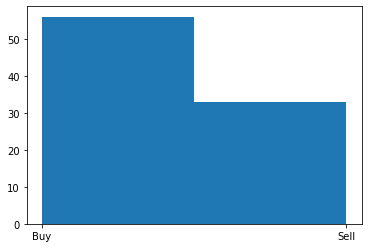

In [18]:
y_pred = classifier.predict(X_test)
plt.hist(y_pred, bins=2);

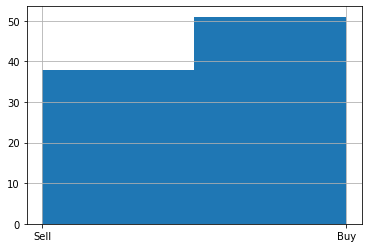

In [19]:
y_test.hist(bins=2);

### Measuring the performance of the model

Accuracy score of the model is:  0.5168539325842697


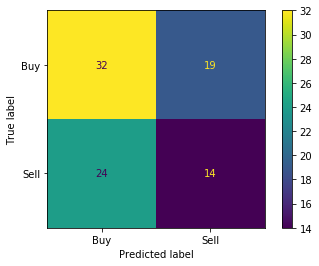

In [20]:
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
plot_confusion_matrix(classifier, X_test, y_test);

### Tuning Hyperparameters

In [21]:
accuracy ={}
for i in range(1,300):
    classifier = RandomForestClassifier(n_estimators=i, random_state=15)
    classifier.fit(X_train, y_train)
    y_pred_ev = classifier.predict(X_test)
    accuracy[i] = accuracy_score(y_test, y_pred_ev)

In [22]:
max(accuracy.values())

0.5842696629213483

In [23]:
value = max(accuracy.values())
for key, val in accuracy.items():
    if val == value:
        print(key)

2
39
40
42
66
67
68
69
79
82
111
153
154
156
158
172
191
193
219


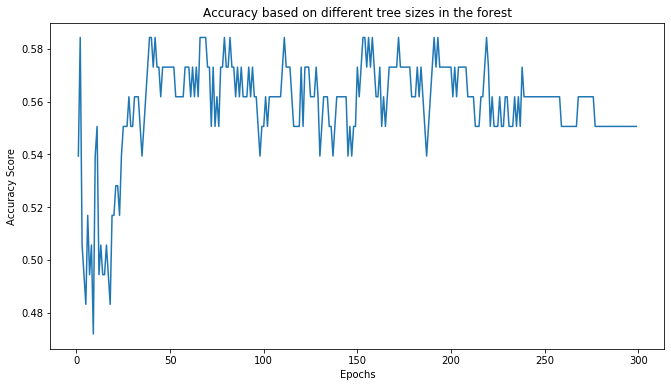

In [24]:
plt.figure(figsize=(11 , 6))
plt.plot(list(accuracy.keys()), list(accuracy.values()))
plt.title('Accuracy based on different tree sizes in the forest')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.show()

##### Looks like 2 (among others) trees gives best accuracy of the model

#### Lets Check another ML model i.e. Support Vector Classifier

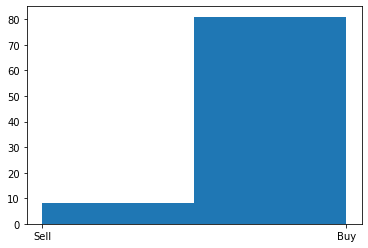

In [25]:
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_train, y_train)
y_pred_1 = clf.predict(X_test)
plt.hist(y_pred_1, bins=2);

Accuracy score of the model is:  0.5955056179775281


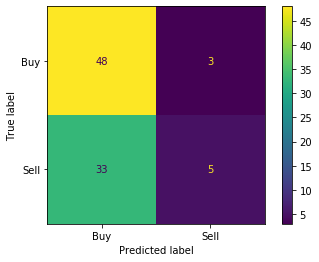

In [26]:
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred_1))
plot_confusion_matrix(clf, X_test, y_test);

### Support Vector Classifier is the better predictor of the stock prices.

### Validation of data
Now let us validate the data with latest stock prices to validate our results.

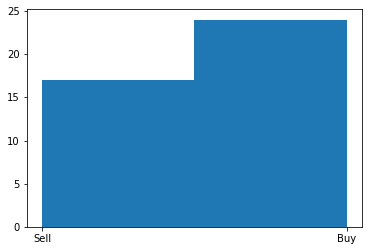

In [33]:
ticker_v = ['GOOG']
start_date_v = '2020-10-02'
end_date_v = '2020-12-31'

df_v, ticker_not_found = get_stock_data(ticker, start_date, end_date)
features_v = get_clean_data(df_v, start_date_v, end_date_v)
X_val = features_v.drop(['stock_move','high', 'low'], axis=1)
y_val = features_v['stock_move']
X_val = scaler.transform(X_val)
clf.fit(X_val, y_val)
y_pred_v = clf.predict(X_val)
plt.hist(y_pred_v, bins=2);

Accuracy score of the model is:  0.6341463414634146


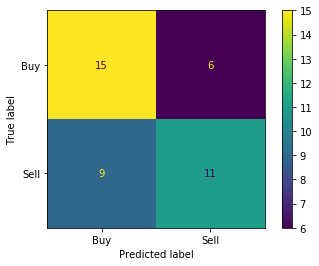

In [34]:
print ("Accuracy score of the model is: ", accuracy_score(y_val, y_pred_v))
plot_confusion_matrix(clf, X_val, y_val);

#### Our SVC model on the validation data has improved alot. 

### Q3-Whether we can use supervised ML classifier Models to predict whether the stock price will go up or down on any given day?
Our model has more accuracy on out-of-sample data. Which is encouraging. However, it is still far from ready to be used in the live trading environment. Based on the preliminary exploration of the models, it does look like that under some conditions, we can use the ML classifiers to get the expected movement of the stock prices.